## 1.12  ASTAttGRU_AttTwoChannelTrans_in_paper

In [2]:
import pickle

In [3]:
path = "/datadrive/enshi/output_clen12/diff_parameter_HGCN/output_HGCN_meandp07hdim/predict/ASTAttGRU_AttTwoChannelTrans.pkl"
data = pickle.load(open(path,"rb"))


In [4]:
data.keys()

dict_keys([' preds', 'trgs', 'test_fids'])

In [5]:
preds_Trans_in_paper,trgs_Trans_in_paper, test_fids_Trans_in_paper =data[' preds'],data['trgs'],data['test_fids'],

# 1.11 ASTAttGRU_Bert_in_paper

In [6]:
path = "/datadrive/enshi/output_clen12/diff_bert/output_diff_decoder_BertAtt_case3/predict/ASTAttGRU_BertAtt.pkl"
data = pickle.load(open(path,"rb"))
preds_Bert_in_paper,trgs_Bert_in_paper, test_fids_Bert_in_paper =data[' preds'],data['trgs'],data['test_fids'],

## 1.6 ast-att-gru

In [7]:
path = "/datadrive/enshi/output_clen12/output_diff_modeltype_hdim256/predict/ast-att-gru.pkl"
data = pickle.load(open(path,"rb"))
preds_ast_att_gru,trgs_ast_att_gru, test_fids_ast_att_gru  =data[' preds'],data['trgs'],data['test_fids'],

## 1.7 att-gru

In [8]:
path = "/datadrive/enshi/output_clen12/output_diff_modeltype_hdim256/predict/att-gru.pkl"
data = pickle.load(open(path,"rb"))
preds_att_gru,trgs_att_gru, test_fids_att_gru  =data[' preds'],data['trgs'],data['test_fids'],

##  1.8 deepcom

In [9]:
path = "/datadrive/enshi/output_clen12/output_diff_modeltype_hdim256/predict/h-deepcom.pkl"
data = pickle.load(open(path,"rb"))
preds_deepcom,trgs_deepcom, test_fids_deepcom =data[' preds'],data['trgs'],data['test_fids'],

## 1.9 codenn

In [10]:
path = "/datadrive/enshi/output_clen12/output_diff_modeltype_hdim256/predict/codenn.pkl"
data = pickle.load(open(path,"rb"))
preds_codenn,trgs_codenn, test_fids_codenn =data[' preds'],data['trgs'],data['test_fids'],

In [11]:
import pickle
import time

In [12]:
code_tokens = pickle.load(open("/datadrive/Data/csn/code/djl1_dfp0_dsi1_dlc1_dr1.pkl","rb"))
summary_tokens =  pickle.load(open("/datadrive/Data/csn/summary/cfp1_csi1_cfd0_clc1.pkl","rb"))

In [13]:
import sys
sys.path.append("/datadrive/CodeSum/")
from util.meteor.meteor import Meteor
from util.rouge.rouge import Rouge
from util.cider.cider import Cider
from util.CustomedBleu.smooth_bleu import smooth_bleu
import numpy as np

In [14]:
def compute_smooth_bleu(refs, preds):
   
    r_str_list = []
    p_str_list = []
    for r, p in zip(refs, preds):
        if len(r[0]) == 0 or len(p) == 0:
            continue

        r_str_list.append([" ".join([str(token_id) for token_id in r[0]])])
        p_str_list.append(" ".join([str(token_id) for token_id in p]))

    bleu_list = smooth_bleu(r_str_list, p_str_list)
        
    return bleu_list[0]

In [15]:
def calculate_four_metric(code_tokens, preds_in_paper, trgs_in_paper, test_fids_in_paper):
    st = time.perf_counter()
    refs_dict = {}
    preds_dict = {}
    for i in range(len(preds_in_paper)):
        preds_dict[i] = [" ".join(preds_in_paper[i])]
        refs_dict[i] = [" ".join(trgs_in_paper[i][0])]
    _, scores_Meteor_Trans = Meteor().compute_score(refs_dict, preds_dict)
    _, scores_Rouge_Trans = Rouge().compute_score(refs_dict, preds_dict)
    _, scores_Cider_Trans = Cider().compute_score(refs_dict, preds_dict)

    step_size = 1
    scores_Meteor_var_codelen = {}
    scores_Rouge_var_codelen = {}
    scores_Cider_var_codelen = {}
    scores_BLEU_var_codelen = {}
    # Bas_code_len ={}
    # codeBerts_code_len ={}
    count_code_len = {}

    for code_len in range(1, 250, step_size):
        scores_Meteor_var_codelen[code_len] = []
        scores_Rouge_var_codelen[code_len] = []
        scores_Cider_var_codelen[code_len] = []
        predict = []
        target = []
        count_code_len[code_len] = 0
        for num in range(len(test_fids_in_paper)):
            fid = test_fids_in_paper[num]
            if len(code_tokens["test"][fid]) == code_len:
                predict.append(preds_in_paper[num])
                target.append(trgs_in_paper[num])
                count_code_len[code_len] += 1
                scores_Meteor_var_codelen[code_len].append(scores_Meteor_Trans[num])
                scores_Rouge_var_codelen[code_len].append(scores_Rouge_Trans[num])
                scores_Cider_var_codelen[code_len].append(scores_Cider_Trans[num])
        if len(predict) == 0:
            continue
        scores_BLEU_var_codelen[code_len] = compute_smooth_bleu(target, predict)

    for i in scores_Meteor_var_codelen:
        scores_Meteor_var_codelen[i] = np.mean(scores_Meteor_var_codelen[i])
        scores_Rouge_var_codelen[i] = np.mean(scores_Rouge_var_codelen[i])
        scores_Cider_var_codelen[i] = np.mean(scores_Cider_var_codelen[i])
    print("time cost: ", time.perf_counter() - st)
    return count_code_len, scores_BLEU_var_codelen,  scores_Meteor_var_codelen, scores_Rouge_var_codelen,scores_Cider_var_codelen

In [16]:
def calculate_four_metric_diff_sum(sum_tokens, preds_in_paper, trgs_in_paper, test_fids_in_paper):
    st = time.perf_counter()
    refs_dict = {}
    preds_dict = {}
    for i in range(len(preds_in_paper)):
        preds_dict[i] = [" ".join(preds_in_paper[i])]
        refs_dict[i] = [" ".join(trgs_in_paper[i][0])]
    _, scores_Meteor_Trans = Meteor().compute_score(refs_dict, preds_dict)
    _, scores_Rouge_Trans = Rouge().compute_score(refs_dict, preds_dict)
    _, scores_Cider_Trans = Cider().compute_score(refs_dict, preds_dict)

    step_size = 1
    scores_Meteor_var_sumlen = {}
    scores_Rouge_var_sumlen = {}
    scores_Cider_var_sumlen = {}
    scores_BLEU_var_sumlen = {}
    # Bas_code_len ={}
    # codeBerts_code_len ={}
    count_sum_len = {}
    # for sum_len in range(30):
    for sum_len in range(1, 31, step_size):
        scores_Meteor_var_sumlen[sum_len] = []
        scores_Rouge_var_sumlen[sum_len] = []
        scores_Cider_var_sumlen[sum_len] = []
        predict = []
        target = []
        count_sum_len[sum_len] = 0
        for num in range(len(test_fids_in_paper)):
            fid = test_fids_in_paper[num]
            if len(sum_tokens["test"][fid]) == sum_len:
                predict.append(preds_in_paper[num])
                target.append(trgs_in_paper[num])
                count_sum_len[sum_len] += 1
                scores_Meteor_var_sumlen[sum_len].append(scores_Meteor_Trans[num])
                scores_Rouge_var_sumlen[sum_len].append(scores_Rouge_Trans[num])
                scores_Cider_var_sumlen[sum_len].append(scores_Cider_Trans[num])
        if len(predict) == 0:
            continue
        scores_BLEU_var_sumlen[sum_len] = compute_smooth_bleu(target, predict)

    for i in scores_Meteor_var_sumlen:
        scores_Meteor_var_sumlen[i] = np.mean(scores_Meteor_var_sumlen[i])
        scores_Rouge_var_sumlen[i] = np.mean(scores_Rouge_var_sumlen[i])
        scores_Cider_var_sumlen[i] = np.mean(scores_Cider_var_sumlen[i])
    print("time cost: ", time.perf_counter() - st)
    return count_sum_len, scores_BLEU_var_sumlen,  scores_Meteor_var_sumlen, scores_Rouge_var_sumlen,scores_Cider_var_sumlen

## code uml

In [17]:
count_code_len, scores_BLEU_Trans_var_codelen,  \
scores_Meteor_Trans_var_codelen, scores_Rouge_Trans_var_codelen,\
scores_Cider_Trans_var_codelen = calculate_four_metric \
(code_tokens,preds_Trans_in_paper,trgs_Trans_in_paper, test_fids_Trans_in_paper)

time cost:  21.859844302758574


/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [18]:
count_sum_len, scores_BLEU_UmlCodeSum_var_sumlen,  \
scores_Meteor_UmlCodeSum_var_sumlen, scores_Rouge_UmlCodeSum_var_sumlen,\
scores_Cider_UmlCodeSum_var_sumlen = calculate_four_metric_diff_sum \
(summary_tokens ,preds_Trans_in_paper,trgs_Trans_in_paper, test_fids_Trans_in_paper)

time cost:  22.485898142680526


/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## bert

In [19]:
count_code_len, scores_BLEU_Bert_var_codelen,  \
scores_Meteor_Bert_var_codelen, scores_Rouge_Bert_var_codelen,\
scores_Cider_Bert_var_codelen = calculate_four_metric \
(code_tokens,preds_Bert_in_paper,trgs_Bert_in_paper, test_fids_Bert_in_paper)

time cost:  21.801459530368447


/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [20]:
count_sum_len, scores_BLEU_Bert_var_sumlen,  \
scores_Meteor_Bert_var_sumlen, scores_Rouge_Bert_var_sumlen,\
scores_Cider_Bert_var_sumlen = calculate_four_metric_diff_sum \
(summary_tokens ,preds_Bert_in_paper,trgs_Bert_in_paper, test_fids_Bert_in_paper)

time cost:  20.838767947629094


/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## codenn

In [21]:
count_code_len, scores_BLEU_codenn_var_codelen,  \
scores_Meteor_codenn_var_codelen, scores_Rouge_codenn_var_codelen,\
scores_Cider_codenn_var_codelen = calculate_four_metric \
(code_tokens,preds_codenn,trgs_codenn, test_fids_codenn)

time cost:  21.194594344124198


/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
count_sum_len, scores_BLEU_codenn_var_sumlen,  \
scores_Meteor_codenn_var_sumlen, scores_Rouge_codenn_var_sumlen,\
scores_Cider_codenn_var_sumlen = calculate_four_metric_diff_sum \
(summary_tokens,preds_codenn,trgs_codenn, test_fids_codenn)

time cost:  21.667992813512683


/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


##  h-deepcom

In [23]:
count_code_len, scores_BLEU_deepcom_var_codelen,  \
scores_Meteor_deepcom_var_codelen, scores_Rouge_deepcom_var_codelen,\
scores_Cider_deepcom_var_codelen = calculate_four_metric \
(code_tokens,preds_deepcom,trgs_deepcom, test_fids_deepcom )

time cost:  20.52045874670148


/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [24]:
ount_sum_len, scores_BLEU_deepcom_var_sumlen,  \
scores_Meteor_deepcom_var_sumlen, scores_Rouge_deepcom_var_sumlen,\
scores_Cider_deepcom_var_sumlen = calculate_four_metric_diff_sum \
(summary_tokens ,preds_deepcom,trgs_deepcom, test_fids_deepcom )

time cost:  19.574360312893987


/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## ast_attendgru

In [25]:
count_code_len, scores_BLEU_ast_attendgru_var_codelen,  \
scores_Meteor_ast_attendgru_var_codelen, scores_Rouge_ast_attendgru_var_codelen,\
scores_Cider_ast_attendgru_var_codelen = calculate_four_metric \
(code_tokens,preds_ast_att_gru,trgs_ast_att_gru, test_fids_ast_att_gru)

time cost:  22.13113608583808


/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [26]:
count_sum_len, scores_BLEU_ast_att_gru_var_sumlen,  \
scores_Meteor_ast_att_gru_var_sumlen, scores_Rouge_ast_att_gru_var_sumlen,\
scores_Cider_ast_att_gru_var_sumlen = calculate_four_metric_diff_sum \
(summary_tokens ,preds_ast_att_gru,trgs_ast_att_gru, test_fids_ast_att_gru)

time cost:  23.313452063128352


/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## plot 

In [54]:
import matplotlib.pyplot as plt

In [69]:
codeuml_lable = 'CoCoGUM'
bert_lable = r'$\rm{CoCoGUM_m}$'
ast_attendgru_label = 'Ast-attendgru'
h_deppcom_lable= 'H-Deepcom'
codenn_lable = 'Code-NN'
plt.rc('text', usetex = False)

In [99]:
def plot_five_bleu(s1_data, s2_data,s3_data,s4_data,s5_data,xlabel,ylabel,step,maxsize,file):
    s1= {}
    s2 = {}
    s3 = {}
    s4 = {}
    s5 = {}
    for i in s1_data:
        if i %step ==0 and i<maxsize:
            s1[i] = s1_data[i]
            s2[i] = s2_data[i]
            s3[i] = s3_data[i]
            s4[i] = s4_data[i]
            s5[i] = s5_data[i]
    fontsize = 15
#     print(s1)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.plot(list(s1.keys()), list(s1.values()), marker='^', linewidth=2.0, markersize=10, label=codeuml_lable )
    ax.plot(list(s2.keys()), list(s2.values()), marker='*', linewidth=2.0, markersize=10, label=bert_lable)
    ax.plot(list(s3.keys()), list(s3.values()), marker='o', linewidth=2.0, markersize=10, label=ast_attendgru_label)
    ax.plot(list(s4.keys()), list(s4.values()), marker='s', linewidth=2.0, markersize=10, label=h_deppcom_lable)
    ax.plot(list(s5.keys()), list(s5.values()), marker='p', linewidth=2.0, markersize=10, label=codenn_lable)    
    ax.legend(fontsize='10',ncol=1) #, loc='upper center'
    
    my_x_ticks =list(s1.keys())
    plt.xticks(my_x_ticks,fontsize='10')
#     plt.yticks(np.arange(0.150,0.430,0.025))
#     plt.yticks(np.arange(0.06,0.25,0.02),fontsize='10')
#     plt.yticks(np.arange(0.15,0.45,0.05),fontsize='10')
#     plt.yticks(np.arange(0.2,1.7,0.2),fontsize='10')
    plt.yticks(fontsize='10')
    plt.show()
    fig.savefig(file)

## summary

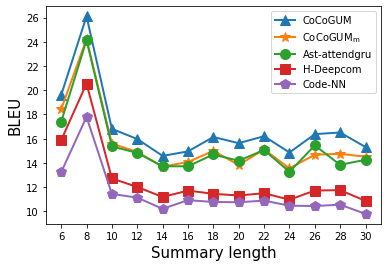

In [70]:
plot_five_bleu( scores_BLEU_UmlCodeSum_var_sumlen,scores_BLEU_Bert_var_sumlen, \
                scores_BLEU_ast_att_gru_var_sumlen, scores_BLEU_deepcom_var_sumlen,
                 scores_BLEU_codenn_var_sumlen, "Summary length","BLEU",2,31, './Figure/varsum_bleu.pdf')

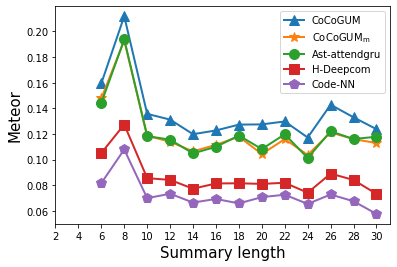

In [71]:
plot_five_bleu( scores_Meteor_UmlCodeSum_var_sumlen,scores_Meteor_Bert_var_sumlen, \
                scores_Meteor_ast_att_gru_var_sumlen, scores_Meteor_deepcom_var_sumlen,
                 scores_Meteor_codenn_var_sumlen, "Summary length","Meteor",2,31,'./Figure/varsum_meteor.pdf')

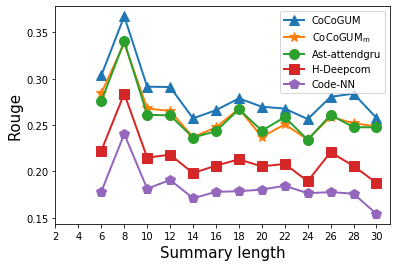

In [100]:
plot_five_bleu( scores_Rouge_UmlCodeSum_var_sumlen,scores_Rouge_Bert_var_sumlen, \
                scores_Rouge_ast_att_gru_var_sumlen, scores_Rouge_deepcom_var_sumlen,
                 scores_Rouge_codenn_var_sumlen, "Summary length","Rouge",2,31,'./Figure/varsum_rouge.pdf')

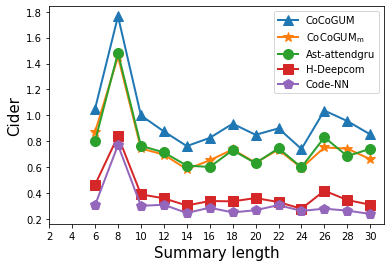

In [73]:
plot_five_bleu( scores_Cider_UmlCodeSum_var_sumlen,scores_Cider_Bert_var_sumlen, \
                scores_Cider_ast_att_gru_var_sumlen, scores_Cider_deepcom_var_sumlen,
                 scores_Cider_codenn_var_sumlen, "Summary length","Cider",2,31,'./Figure/varsum_cider.pdf')

## code

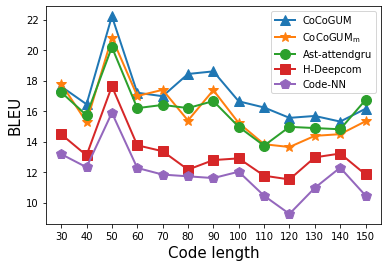

In [74]:
plot_five_bleu( scores_BLEU_Trans_var_codelen,scores_BLEU_Bert_var_codelen, \
                scores_BLEU_ast_attendgru_var_codelen, scores_BLEU_deepcom_var_codelen,
                 scores_BLEU_codenn_var_codelen, "Code length","BLEU",10,151,'./Figure/varcode_bleu.pdf')

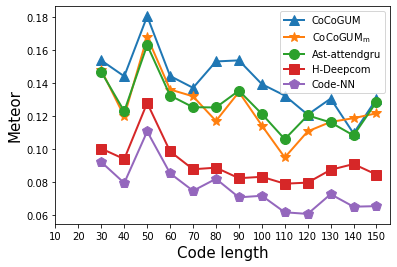

In [75]:
plot_five_bleu( scores_Meteor_Trans_var_codelen,scores_Meteor_Bert_var_codelen, \
                scores_Meteor_ast_attendgru_var_codelen, scores_Meteor_deepcom_var_codelen,
                 scores_Meteor_codenn_var_codelen, "Code length","Meteor",10,151,'./Figure/varcode_meteor.pdf')

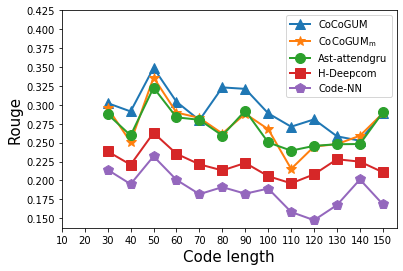

In [79]:
plot_five_bleu( scores_Rouge_Trans_var_codelen,scores_Rouge_Bert_var_codelen, \
                scores_Rouge_ast_attendgru_var_codelen, scores_Rouge_deepcom_var_codelen,
                 scores_Rouge_codenn_var_codelen, "Code length","Rouge",10,151,'./Figure/varcode_rouge.pdf')

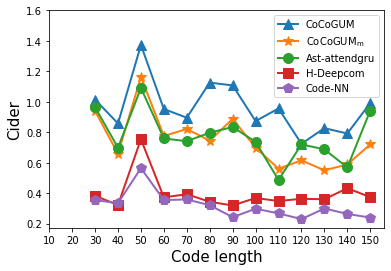

In [82]:
plot_five_bleu( scores_Cider_Trans_var_codelen,scores_Cider_Bert_var_codelen, \
                scores_Cider_ast_attendgru_var_codelen, scores_Cider_deepcom_var_codelen,
                 scores_Cider_codenn_var_codelen, "Code length","Cider",10,151,'./Figure/varcode_cider.pdf')

## Without CoCoGUM_m

In [101]:
def plot_four_bleu_without_cocogum_m(s1_data, s2_data,s3_data,s4_data,s5_data,xlabel,ylabel,step,maxsize,file):
    s1= {}
    s2 = {}
    s3 = {}
    s4 = {}
    s5 = {}
    for i in s1_data:
        if i %step ==0 and i<maxsize:
            s1[i] = s1_data[i]
            s2[i] = s2_data[i]
            s3[i] = s3_data[i]
            s4[i] = s4_data[i]
            s5[i] = s5_data[i]
    fontsize = 15
#     print(s1)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.plot(list(s1.keys()), list(s1.values()), marker='^', linewidth=2.0, markersize=10, label=codeuml_lable )
#     ax.plot(list(s2.keys()), list(s2.values()), marker='*', linewidth=2.0, markersize=10, label=bert_lable)
    ax.plot(list(s3.keys()), list(s3.values()), marker='o', linewidth=2.0, markersize=10, label=ast_attendgru_label)
    ax.plot(list(s4.keys()), list(s4.values()), marker='s', linewidth=2.0, markersize=10, label=h_deppcom_lable)
    ax.plot(list(s5.keys()), list(s5.values()), marker='p', linewidth=2.0, markersize=10, label=codenn_lable)    
    ax.legend(fontsize='10',ncol=1) #, loc='upper center'
    
    my_x_ticks =list(s1.keys())
    plt.xticks(my_x_ticks,fontsize='10')
    plt.yticks(np.arange(0.150,0.430,0.025))
#     plt.yticks(np.arange(0.06,0.25,0.02),fontsize='10')
#     plt.yticks(np.arange(0.15,0.45,0.05),fontsize='10')
#     plt.yticks(np.arange(0.2,1.7,0.2),fontsize='10')
    plt.yticks(fontsize='10')
    plt.show()
    fig.savefig(file)

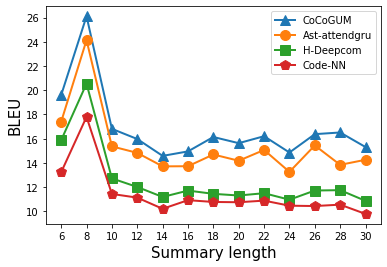

In [88]:
plot_four_bleu_without_cocogum_m( scores_BLEU_UmlCodeSum_var_sumlen,scores_BLEU_Bert_var_sumlen, \
                scores_BLEU_ast_att_gru_var_sumlen, scores_BLEU_deepcom_var_sumlen,
                 scores_BLEU_codenn_var_sumlen, "Summary length","BLEU",2,31, './Figure/varsum_bleu(withou_cocoGUM).pdf')

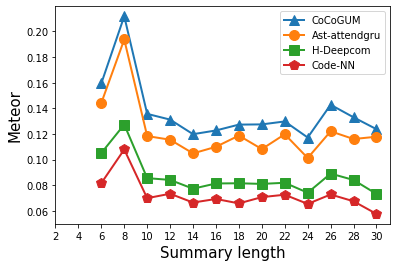

In [90]:
plot_four_bleu_without_cocogum_m( scores_Meteor_UmlCodeSum_var_sumlen,scores_Meteor_Bert_var_sumlen, \
                scores_Meteor_ast_att_gru_var_sumlen, scores_Meteor_deepcom_var_sumlen,
                 scores_Meteor_codenn_var_sumlen, "Summary length","Meteor",2,31,'./Figure/varsum_meteor(withou_cocoGUM).pdf')

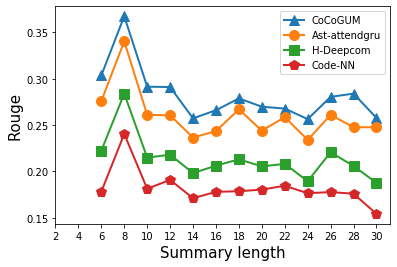

In [92]:
plot_four_bleu_without_cocogum_m( scores_Rouge_UmlCodeSum_var_sumlen,scores_Rouge_Bert_var_sumlen, \
                scores_Rouge_ast_att_gru_var_sumlen, scores_Rouge_deepcom_var_sumlen,
                 scores_Rouge_codenn_var_sumlen, "Summary length","Rouge",2,31,'./Figure/varsum_rouge(withou_cocoGUM).pdf')

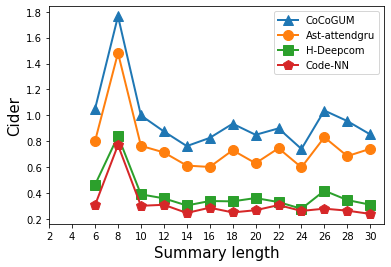

In [93]:
plot_four_bleu_without_cocogum_m( scores_Cider_UmlCodeSum_var_sumlen,scores_Cider_Bert_var_sumlen, \
                scores_Cider_ast_att_gru_var_sumlen, scores_Cider_deepcom_var_sumlen,
                 scores_Cider_codenn_var_sumlen, "Summary length","Cider",2,31,'./Figure/varsum_cider(withou_cocoGUM).pdf')

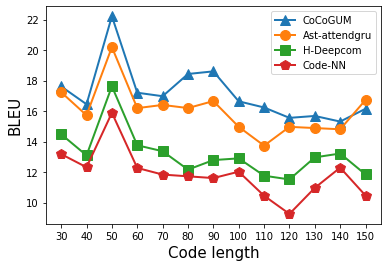

In [94]:
plot_four_bleu_without_cocogum_m( scores_BLEU_Trans_var_codelen,scores_BLEU_Bert_var_codelen, \
                scores_BLEU_ast_attendgru_var_codelen, scores_BLEU_deepcom_var_codelen,
                 scores_BLEU_codenn_var_codelen, "Code length","BLEU",10,151,'./Figure/varcode_bleu(withou_cocoGUM).pdf')

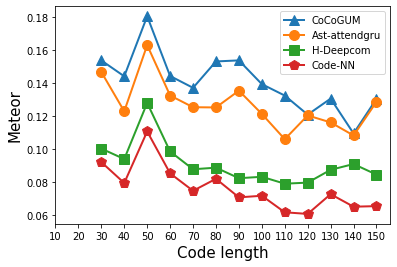

In [95]:
plot_four_bleu_without_cocogum_m( scores_Meteor_Trans_var_codelen,scores_Meteor_Bert_var_codelen, \
                scores_Meteor_ast_attendgru_var_codelen, scores_Meteor_deepcom_var_codelen,
                 scores_Meteor_codenn_var_codelen, "Code length","Meteor",10,151,'./Figure/varcode_meteor(withou_cocoGUM).pdf')

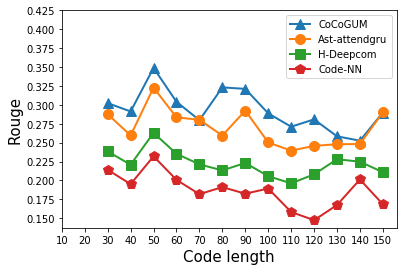

In [102]:
plot_four_bleu_without_cocogum_m( scores_Rouge_Trans_var_codelen,scores_Rouge_Bert_var_codelen, \
                scores_Rouge_ast_attendgru_var_codelen, scores_Rouge_deepcom_var_codelen,
                 scores_Rouge_codenn_var_codelen, "Code length","Rouge",10,151,'./Figure/varcode_rouge(withou_cocoGUM).pdf')

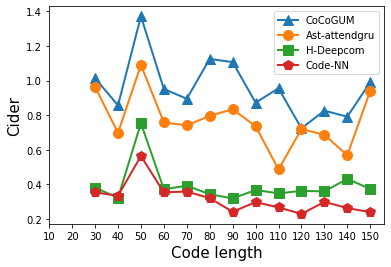

In [97]:
plot_four_bleu_without_cocogum_m( scores_Cider_Trans_var_codelen,scores_Cider_Bert_var_codelen, \
                scores_Cider_ast_attendgru_var_codelen, scores_Cider_deepcom_var_codelen,
                 scores_Cider_codenn_var_codelen, "Code length","Cider",10,151,'./Figure/varcode_cider(withou_cocoGUM).pdf')